In [16]:
# import matplotlib
# %matplotlib notebook

# How to create a Butterworth IIR Lowpass-filter with arbitrary steepness

## Problem Statement

Lowpass filters (using the standard Butterworth design) are attached to a well-defined steepness, like 6dB / Oct per order of the filter. Most common for musical applications are second or fourth order filters with 12 and 24 db/Oct respectiviliy.

Unfortunetly, these values are only valid for the analog design due to the bilinear transform (see figure), nor can we design filters with 4dB/Oct or 14dB/Oct. 

Both limitations can be addressed by the proposed method.

### Example for the BLT problem


<IPython.core.display.Javascript object>


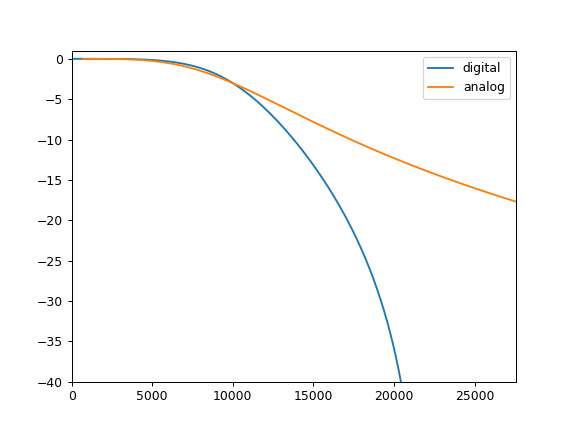

In [17]:
import numpy as np
from scipy import signal
from matplotlib import pyplot
from math import pi 

# define filter
order = 2
samplerate = 44_100 
cutoff_freq = 10_000 

# get digital transfer function
b, a = signal.butter(N=order, Wn=2*cutoff_freq/samplerate)
w_dig, H_dig = signal.freqz(b, a) 



# get analog transfer function
b_ana, a_ana = signal.butter(order, 2*pi*cutoff_freq/samplerate, analog=True) 
w_ana, H_ana = signal.freqs(b_ana, a_ana)

# plot results
fig, ax = pyplot.subplots()
ax.plot(w_dig/pi*samplerate/2, 20*np.log10(abs(H_dig)), 
        label='digital') 
ax.plot(w_ana/pi*samplerate/2, 20*np.log10(abs(H_ana)), 
        label='analog')
ax.set(xlim=[0, samplerate/2+samplerate/8], ylim=[-40, 1])
ax.legend()

## Solution

The proposed solution is based on the FDLS (Frequency Domain Least Squares) approach for IIR filter design [1] as a final step (you can use this alone to solve for the BLT problem) (skip the next section about arbitrary steepness)

[1] G. Berchin, "Precise Filter Design [DSP Tips & Tricks]," in IEEE Signal Processing Magazine, vol. 24, no. 1, pp. 137-139, Jan. 2007.
doi: 10.1109/MSP.2007.273077

### Arbitrary steepness

#### Buterworth design background:

Many people use butterworth filters, but they are not aware of the fundamental design procedure. Butterworth filter (also known as maximmal flat filter), is the optimal solution at $$\omega = 0$$ in terms of steepness, which is zero and therefore maximally flat. The design function for Butterworth filters is $$s \mbox{'}^{n}$$ in the helper function K(s) (Laplace domain). n = order of the filter, and $$s\mbox{'} = \frac{s}{\omega_{cut}}$$ as the normalized s domain paramter after lowpass-lowpass transformation.

$$H(s\mbox{'})H(-s\mbox{'}) = \frac{1}{1+C^2 K(s\mbox{'}) K(-s\mbox{'})}$$

which results in

$$H(s\mbox{'})H(-s\mbox{'}) = \frac{1}{1+\mbox{C}^2 (-1)^n s \mbox{'}^{2n}}$$

with $$C = 1$$ we design the filter at the -3dB design point.

#### Example for n = 2,3,4

<IPython.core.display.Javascript object>


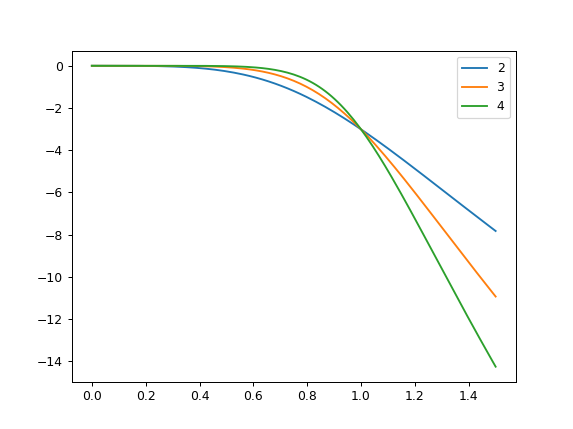

In [18]:
def butterworth_tf(order, maxdisplay_freq, length, C=1):
    "Calculates a normalized butterworth transfer function with integer order"
    norm_freqs = np.linspace(0.0, maxdisplay_freq, num=length//2+1)
    jw = 1j*norm_freqs 
    tf = np.abs(1/(1+C**2 * (-1)**order * jw**(2*order)))
    return norm_freqs, 10*np.log10(tf)

fig, ax = pyplot.subplots()
for n in [2, 3, 4]: 
    ax.plot(*butterworth_tf(order=n, maxdisplay_freq=1.5, length=256), label = n)
    
ax.legend()

#### Non-integer order
The transfer function can be computed for all n. it is not limited to integers. Of course, we could not design such filters with the classical methods and we have to go back to the original  design routine. For future use, it is helpfull, to think a little digital. the transfer function will work up to the half of the sample rate. Therefore, we will design our arbitrary butterworth filter in terms of the cutoff frequency and the samplerate.
The result is a TF with the desired arbitrary steepness in the range of 0Hz to samplerate/2, which will be our design goal.

<IPython.core.display.Javascript object>


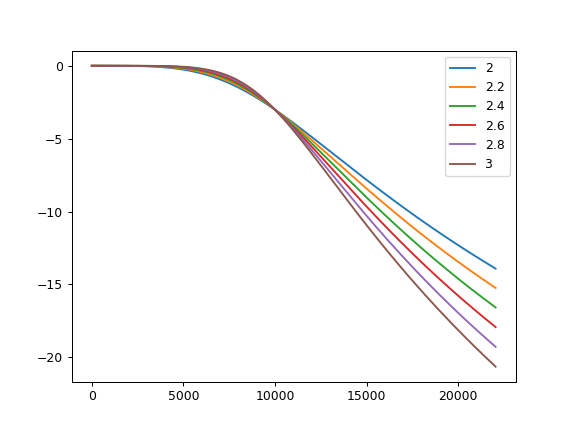

In [19]:
def butterworth_tf_arbitrary(order, cutoff_freq, samplerate, C = 1, length = 256):
    '''compute the transfer function of an arbitrary (non-integer) order butterworth filter.
    This filter can only be designed by classic methods for integer order'''
    analysis_freqs = np.linspace(start=0.0, 
                             stop=samplerate/2, 
                             num=length//2+1)

    jw = 1j*analysis_freqs/cutoff_freq
    magH_squared = abs(1/(1+C**2 * (jw)**(order) *(-jw)**(order))) 
    return analysis_freqs, magH_squared

fig, ax = pyplot.subplots()

#n = [0.2,0.4,0.6,0.8,1] #try other values, especially below 1 ==> n should be  > 0.5
#adjust C to play around

for n in [2,2.2,2.4,2.6,2.8,3]:
    analysis_freqs, magH_squared = butterworth_tf_arbitrary(n , cutoff_freq, samplerate, C = 1, length = 256)
    ax.plot(analysis_freqs,10*np.log10(magH_squared), label = n)

ax.legend()

    

## FDLS Design
The FDLS Design is based on the idea of finding the filter coefficients that fit the transfer function in the least squares sense. Unfortunately, we need a phase for the design routine. A good starting point is always minimum phase, which can be computed from the magnitude transfer function by using the Hilbert transform. 

Lets start with one specific design, e.g. approx 9dB/Oct and compute the magnitude transfer function for it.


<IPython.core.display.Javascript object>


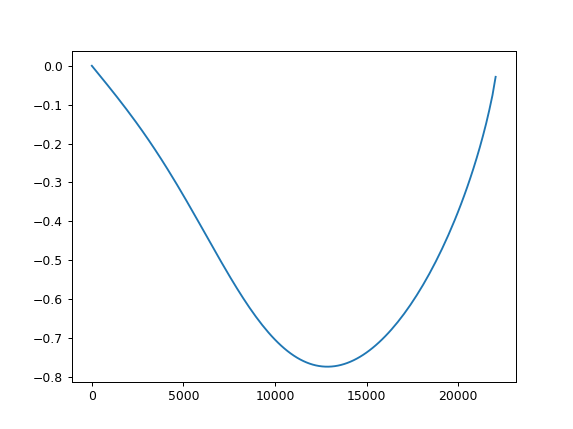

In [20]:
n = 1.5 # lets design a filter with approx 9dB steepness
[freqs, magH_squared] = butterworth_tf_arbitrary(order, cutoff_freq, samplerate, C = 1, length = 256)
def transfermagnitude2minimumphase(magH):
    '''Computes the minimum phase by a given magnitude of the transfer function by using the Hilbert transform'''    
    second_half = magH[-1:0:-1] 
    transfer_function = np.append(magH, second_half)
    tf_length = len(transfer_function)
    hilbert_in = np.log(np.abs(transfer_function))

    hilbert_out = -signal.hilbert(hilbert_in)
    phase = hilbert_out[:tf_length//2+1].imag 
    return phase

phase = transfermagnitude2minimumphase(np.sqrt(magH_squared))

fig, ax = pyplot.subplots()

ax.plot(freqs,phase)

For the FDLS Routine the order should always be increased by one compared to the classic design. In this example the next integer order would be 2. So we choose 3. It would work with 2, but not as well (try it!). The order of the numerator and denominator can be different (but not in this example).

[ 0.5582635   0.14475828 -0.06033516]
[1, -0.484344598244154, 0.12827484093016403]


<IPython.core.display.Javascript object>


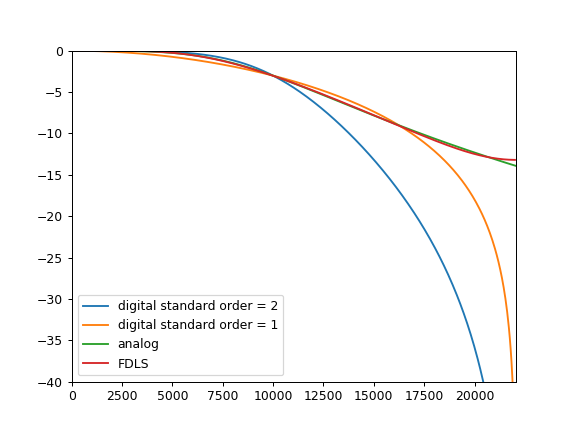

In [21]:
def FDLS_design(order_of_numerator, order_of_denominator, mag_h, phase_h):
    omega = np.linspace(start = 0,
                       stop = pi,
                       num = len(mag_h))
    y = mag_h*np.cos(phase_h); 
    X_D = -mag_h * np.cos(-1 * omega + phase_h); 

    X_D = [X_D]
    for k in range(order_of_denominator-1): 
        X_D.append(-mag_h * np.cos(-(k+2) * omega + phase_h))
    X_D = np.array(X_D).T 

    # non recursive part
    X_N = np.cos(-1 * omega);  

    X_N = [X_N]
    for k in range(order_of_numerator-1):
        X_N.append(np.cos(-(k+2) * omega))    
    X_N = np.array(X_N).T

    #and define X as input matrix
    X = np.hstack([X_D, np.ones([len(mag_h), 1]), X_N])
    coeff = np.linalg.lstsq(X, y, rcond=None)
    a = [1, *coeff[0][:order_of_denominator]] # ANN: einfach eine Liste statt hstack (* fügt Elemente ein, anstatt die ganze Liste)
    b = coeff[0][order_of_denominator:order_of_denominator+order_of_numerator+1]
    return b,a
    
    
# and now design the filter coefficients with FDLS
order_num = 2
order_den = 2
mag_h = np.sqrt(magH_squared)

b,a = FDLS_design(order_num, order_den,mag_h, phase)
print (b)
print (a)
w_fdls, H_fdls = signal.freqz(b, a)

b_order1, a_order1 = signal.butter(N=1, Wn=2*cutoff_freq/samplerate)
w_dig_order1, H_dig_order1 = signal.freqz(b_order1, a_order1) 


# This comparison makes only sense for integer n
fig, ax = pyplot.subplots()
ax.plot(w_dig/pi*samplerate/2, 20*np.log10(abs(H_dig)), label='digital standard order = 2')
ax.plot(w_dig_order1/pi*samplerate/2, 20*np.log10(abs(H_dig_order1)), label='digital standard order = 1')
ax.plot(w_ana/pi*samplerate/2, 20*np.log10(abs(H_ana)), label='analog')
ax.plot(w_fdls/pi*samplerate/2, 20*np.log10(abs(H_fdls)), label='FDLS')
ax.set(ylim=[-40,0], xlim=[0, samplerate/2])
ax.legend()

# Full example
Just to show how easy it is with the given functions, here another example

<IPython.core.display.Javascript object>


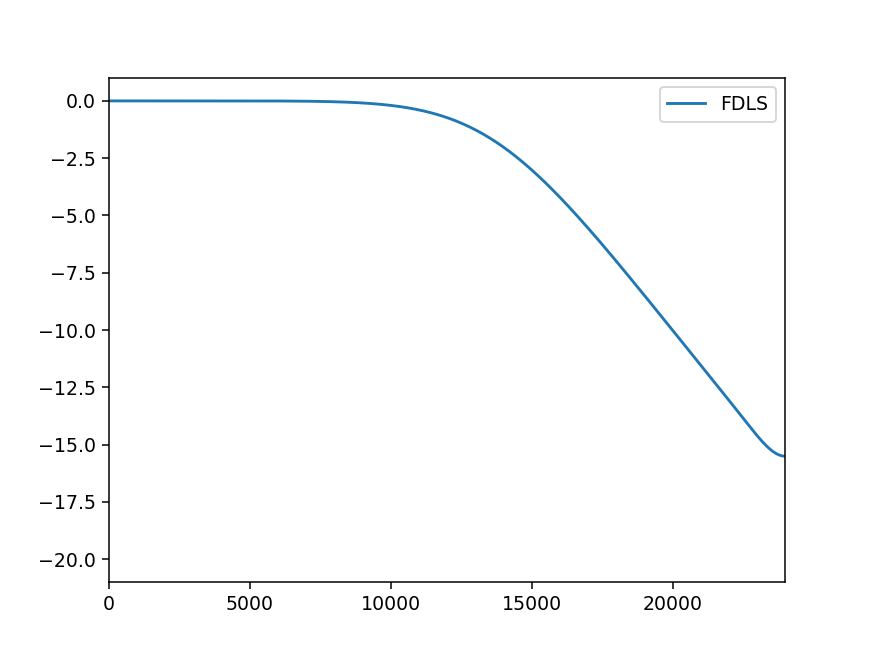

In [108]:
cutoff = 15_000 # you can even use cutoff > samplerate/2 
samplerate = 48_000

desired_order = 3.8

num_order = int(np.ceil(desired_order))+1
den_order = int(np.ceil(desired_order))+1

analysis_freqs, magH_squared = butterworth_tf_arbitrary(desired_order , cutoff, 
                                                        samplerate, C = 1, length = 256)

phase = transfermagnitude2minimumphase(np.sqrt(magH_squared))
mag_h = np.sqrt(magH_squared)
b,a = FDLS_design(num_order, den_order ,mag_h, phase)
w_fdls, H_fdls = signal.freqz(b, a)

fig, ax = pyplot.subplots()
ax.plot(w_fdls/pi*samplerate/2, 20*np.log10(abs(H_fdls)), label='FDLS')
ax.set(ylim=[-21,1], xlim=[0, samplerate/2])
ax.legend()


## Conclusions

Lowpass filter design without BLT distortion and arbitrary steepness is possible at the cost of little more computational complexity.

### Shameless advertisement 
I hope you find this useful, and if you are young (at least at heart), speak German fluently (or are very willing to learn German) and want to learn how to do this and how to implement this stuff as a VST plugin, go to a univerity. I recommend the JADE HOCHSCHULE in Oldenburg, Northern Germany where you can study Hörtechnik und Audiologie (Hearing technology and Audiology).
   